In [7]:
import numpy as np
import torch
from src.models.diffusion.ddpm import DDPM
NUMBER_OF_SAMPLES = 5000 # definiujemy ile próbek ma znaleźć się w zbiorze danych, oraz ile chcemy generować przez model (dla porównania)
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

SEED = 42
np.random.seed(SEED)
torch.random.manual_seed(SEED)
diffusion = DDPM()


Text(0.5, 1.0, 'Moons Dataset')

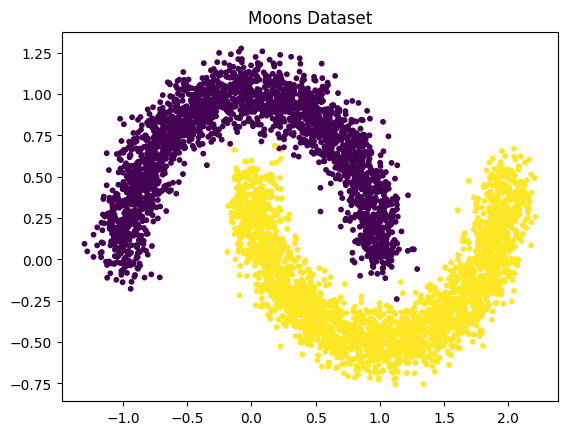

In [8]:
# moons dataset
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
X, y = make_moons(n_samples=NUMBER_OF_SAMPLES, noise=0.1, random_state=42)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=10)
plt.title('Moons Dataset')

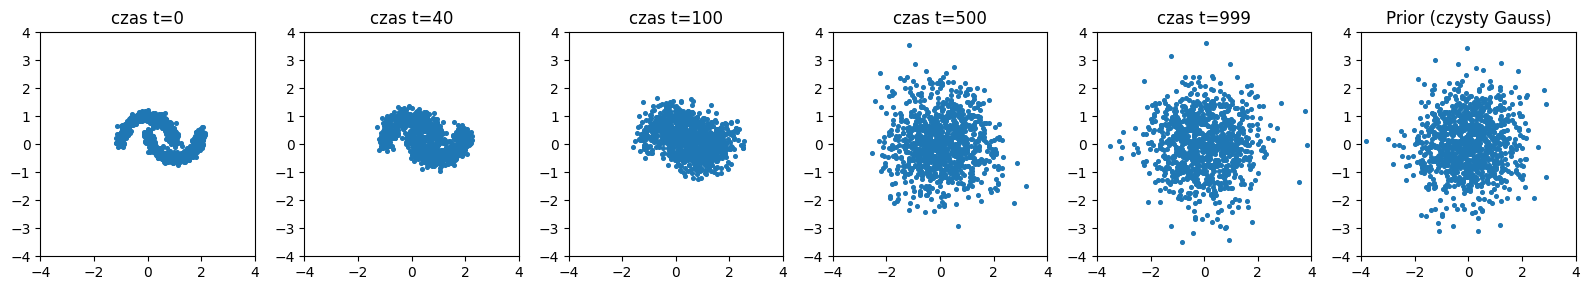

In [9]:

import torch

prior = torch.randn(NUMBER_OF_SAMPLES, 2)
x_0 = torch.tensor(X, dtype=torch.float32)
plt.figure(figsize=(16, 3))

plt.subplot(1, 6, 1)
plt.scatter(x_0[:1000, 0], x_0[:1000, 1], s=7)
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.title("czas t=0")
x_0 = x_0.to(DEVICE)
for i, t in enumerate([40, 100, 500, 999]):
    plt.subplot(1, 6, i + 2)
    x_t = diffusion.q_sample(x_0, torch.tensor([t] * NUMBER_OF_SAMPLES).to(DEVICE)).cpu().numpy()
    plt.scatter(x_t[:1000, 0], x_t[:1000, 1], s=7)
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)
    plt.title(f"czas t={t}")

plt.subplot(1, 6, 6)
plt.scatter(prior[:1000, 0], prior[:1000, 1], s=7)
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.title("Prior (czysty Gauss)")

plt.tight_layout()
plt.show()

In [10]:
%load_ext autoreload
%autoreload 2
from src.models.representation.vae import *
from src.models.representation.vae.vae import RecurrentVaeWithTeacherForcing
from src.models.representation.vae.decoder.recurrent_decoder import LSTMVaeDecoderWithTeacherForcing
from src.dataloader.dataset import *

import pickle

import torch

dataset = pickle.load(open("data/preprocessed_note_events.pkl", "rb"))



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import torch_optimizer
from torch.utils.data import DataLoader
from src.common.diagnostic.summary import show_summary
from src.models.diffusion.ddpm_trainer import DDPMTrainer
from src.models.diffusion.ddpm import DDPM
from src.models.representation.ae.auto_encoder import Autoencoder, Decoder, Encoder

MAX_DELTA_TIME = 2 
MIN_NOTE_DURATION = 0.1
SEQUENCE_LENGTH = 4
RUN_NAME = "ddpm_midi_autoencoder"
BATCH_SIZE = 4096

def collate_fn(batch):
    """
    Custom collate function to handle variable-length sequences in the batch.
    """
    batch = torch.stack(batch, dim=0)
    # batch = batch[:,:SEQUENCE_LENGTH,:]
    batch[:, :, 0] = batch[:, :, 0]/63.5 - 1
    batch[:, :, 2:] = batch[:, :, 2:].clamp(min=MIN_NOTE_DURATION, max=MAX_DELTA_TIME)
    # already scaled to [0, 1]
    batch[:, :, 1:] = batch[:, :, 1:] * 2 - 1

    return batch

midi_dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=0,
    shuffle=True,
    collate_fn=collate_fn
)

encoder = Encoder(
    input_dim=4,
    hidden_dim=128,
    latent_dim=64,
    num_layers=4
)

decoder = Decoder(
    latent_dim=64,
    hidden_dim=128,
    num_layers=4,
    output_dim=4
)

ae_model = Autoencoder(
    encoder=encoder,
    decoder=decoder,
).to(DEVICE)

t = next(iter(midi_dataloader))
show_summary(ae_model, input_shape=t[0].shape, batch_size=t.shape[0], dataset=dataset)


optimizer = torch_optimizer.Lamb(
    ae_model.parameters(),
    lr=1e-3,
    weight_decay=1e-4,
)

diffusion = DDPM(
    1_000
)

trainer = DDPMTrainer(
    model=ae_model,
    optimizer=optimizer,
    diffusion=diffusion,
    run_name=RUN_NAME,
)


Autoencoder(
  (encoder): Encoder(
    (diff_timestep_embedding): Embedding(1000, 128)
    (lstm): LSTM(4, 128, num_layers=4, batch_first=True, dropout=0.1, bidirectional=True)
    (linear): Linear(in_features=256, out_features=64, bias=True)
  )
  (decoder): Decoder(
    (lstm): LSTM(4, 128, num_layers=4, batch_first=True)
    (mom): MemoryOverwriteModule(
      (forget_gate): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): Sigmoid()
      )
      (overwrite_sig): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): Sigmoid()
      )
      (overwrite_tanh): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): Tanh()
      )
    )
    (latent_to_hidden): Linear(in_features=64, out_features=128, bias=True)
    (latent_to_cell): Linear(in_features=64, out_features=128, bias=True)
    (fc_out): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
  

In [12]:
trainer.train(
    midi_dataloader,
    100,
)

Epoch 24/100 - Loss: 0.0850:  24%|██▍       | 24/100 [1:18:48<4:09:32, 197.01s/it]


KeyboardInterrupt: 

In [15]:

trainer.save_model(
    f"models/denoisers/ae/ddpm_midi_autoencoder/ddpm_midi_autoencoder.pth",
)

Saving model to models/denoisers/ae/ddpm_midi_autoencoder/ddpm_midi_autoencoder.pth
Model saved to models/denoisers/ae/ddpm_midi_autoencoder/ddpm_midi_autoencoder.pth/ddpm_midi_autoencoder.pth


In [16]:
t = next(iter(midi_dataloader))
t

tensor([[[ 0.1181,  0.0866, -0.8000, -0.8000],
         [ 0.1969,  0.3071, -0.7526, -0.8000],
         [ 0.2598,  0.4646, -0.7474, -0.8000],
         ...,
         [ 0.2126,  0.3228, -0.8000, -0.7943],
         [ 0.2598,  0.2283, -0.8000, -0.5495],
         [ 0.2126,  0.3071, -0.8000, -0.6536]],

        [[ 0.1969,  0.2126, -0.7552, -0.7005],
         [ 0.0551,  0.2126, -0.8000, -0.7135],
         [-0.0236, -0.0394, -0.8000, -0.8000],
         ...,
         [ 0.1654,  0.2441, -0.8000, -0.8000],
         [ 0.0866,  0.4016, -0.7760, -0.7214],
         [-0.0236, -0.1181, -0.8000, -0.7708]],

        [[-0.0866, -0.1339, -0.8000, -0.6146],
         [ 0.2126,  0.2441, -0.6276,  0.2839],
         [ 0.1654,  0.0236, -0.8000, -0.1276],
         ...,
         [-0.2126, -0.3543, -0.8000,  0.2578],
         [ 0.1654,  0.2756, -0.5964, -0.6328],
         [ 0.1024,  0.1811, -0.8000, -0.6016]],

        ...,

        [[-0.3701, -0.1654, -0.8000, -0.7708],
         [-0.1811, -0.1654, -0.8000, -0.8000]

In [28]:


@torch.inference_mode()
def sampler(model, diffusion: DDPM, noise,) -> np.ndarray:
    model.eval()
    samples = diffusion.p_sample_loop(model, noise, clip=True)
    return samples

noise = torch.randn(1, 8, 4).to(DEVICE)
samples = sampler(ae_model, diffusion, noise)

In [29]:
samples

array([[[ 0.0721684 ,  0.12731832, -0.79804814, -0.80730206],
        [ 0.08628386,  0.02408778, -0.792239  , -0.79740703],
        [ 0.09755356,  0.08698234, -0.79840726, -0.79434836],
        [ 0.08593822,  0.03348855, -0.80204904, -0.7956467 ],
        [ 0.06603187, -0.00600806, -0.80634874, -0.7969989 ],
        [ 0.01608092,  0.08493634, -0.80040437, -0.79810315],
        [ 0.10015482,  0.12662233, -0.8022244 , -0.79946095],
        [ 0.08259484,  0.06678009, -0.79655766, -0.801953  ]]],
      dtype=float32)

In [30]:
def diff_adapter(tensor: torch.Tensor) -> torch.Tensor:
    """
    Adapter function to convert the output of the model to the expected format.
    """
    tensor[:, :, 0] = (tensor[:, :, 0] + 1) * 63.5
    tensor[:, :, 1:] = (tensor[:, :, 1:] + 1) / 2
    return tensor

samples = diff_adapter(samples)
print(samples.shape)

(1, 8, 4)


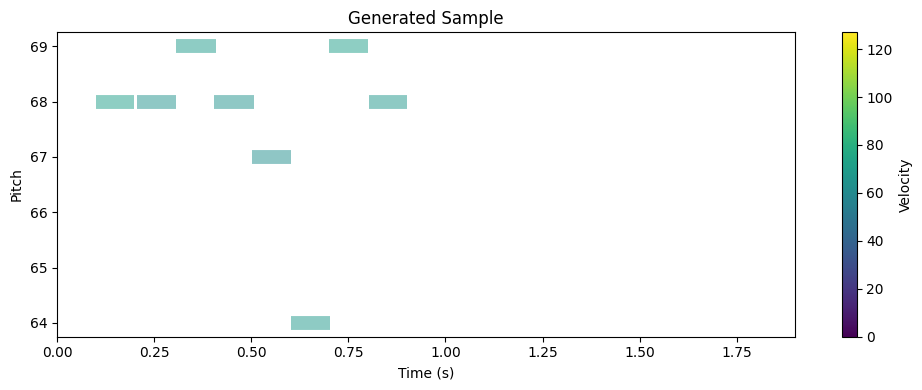

(<Figure size 1000x400 with 2 Axes>,
 <Axes: title={'center': 'Generated Sample'}, xlabel='Time (s)', ylabel='Pitch'>)

In [31]:
from src.common.diagnostic.visualize_note_events import plot_piano_roll_from_note_events


plot_piano_roll_from_note_events(samples[0], title="Generated Sample", show=True)

In [32]:
import pretty_midi


@torch.inference_mode
def note_events_to_pretty_midi(note_array: torch.Tensor | np.ndarray, path="eg.mid", default_program=0):
    if isinstance(note_array, torch.Tensor):
        note_array = note_array.detach().cpu().numpy()
    #scale  and velocities
    note_array[:, 1] *= 127
    # clamp pitches and velocities
    note_array[:, 0] = np.clip(note_array[:, 0], 0, 127)
    note_array[:, 1] = np.clip(note_array[:, 1], 0, 127)
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=default_program)

    current_time = 0.0
    print(note_array.shape)
    for row in note_array:
        pitch, velocity, delta, duration = row
        current_time += delta
        start = current_time
        end = start + duration

        note = pretty_midi.Note(
            velocity=int(velocity),
            pitch=int(pitch),
            start=start,
            end=end
        )
        instrument.notes.append(note)

    pm.instruments.append(instrument)
    pm.write(path)

note_events_to_pretty_midi(samples[0], path="eg_diff.mid", default_program=0)

(8, 4)
